# Preprocess & Modeling (Part III)

### Author: Louis Wong

In [1]:
import boto3
import io
import pandas as pd
import os
from dotenv import load_dotenv

# Load credentials
load_dotenv()
minio_user = os.getenv("MINIO_ROOT_USER")
minio_pass = os.getenv("MINIO_ROOT_PASSWORD")
s3_endpoint = "http://host.docker.internal:9000"

# Set up S3 (MinIO) client
s3 = boto3.client(
    "s3",
    endpoint_url=s3_endpoint,
    aws_access_key_id=minio_user,
    aws_secret_access_key=minio_pass,
    region_name="us-east-1"
)

# Define bucket and key
bucket_name = "gold-data"
key_name = "healthcare-dataset-stroke-data"

# Read the parquet file
objs = s3.list_objects_v2(Bucket="gold-data", Prefix="healthcare-dataset-stroke-data/")
part_file = next(obj["Key"] for obj in objs["Contents"] if obj["Key"].endswith(".parquet"))
body = s3.get_object(Bucket="gold-data", Key=part_file)["Body"].read()
df = pd.read_parquet(io.BytesIO(body))

df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,smoking_status,stroke,bmi,log_glucose_level,age_group
0,Female,81,1,0,1,Private,Rural,80.43,never smoked,1,29.70,4.399744,80+
1,Male,57,0,1,0,Govt_job,Urban,217.08,Unknown,1,32.42,5.384862,50-64
2,Male,82,0,1,1,Private,Rural,208.30,Unknown,1,32.50,5.343769,80+
3,Female,72,1,0,1,Private,Rural,74.63,formerly smoked,1,23.10,4.325853,65-79
4,Male,78,0,0,1,Private,Rural,78.03,formerly smoked,1,23.90,4.369828,65-79


## Preprocess

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
import joblib

SEED = 777

# Load local or S3-based CSV
X = df.drop("stroke", axis=1)
y = df["stroke"]

# Three-way split (Train 60%/ Validation 20% / Test 20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=SEED) # Hold out test (20%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=SEED) # Split remaining 80% into train/val


# Build Preprocessing Pipeline
cat_cols = ["gender", "smoking_status"]
num_cols = ["age", "avg_glucose_level"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
])

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)
X_test_proc  = preprocessor.transform(X_test)

# Apply SMOTE only on training
X_train_sm, y_train_sm = SMOTE(random_state=SEED).fit_resample(X_train_proc, y_train)

# Save preprocessor for inference later
os.makedirs("model", exist_ok=True)
joblib.dump(preprocessor, "model/preprocessor.joblib")

['model/preprocessor.joblib']

In [3]:
from sklearn.datasets import dump_svmlight_file
import os

os.makedirs("ml-local", exist_ok=True)

dump_svmlight_file(X_train_sm, y_train_sm, "ml-local/train.libsvm", zero_based=True)
dump_svmlight_file(X_val_proc, y_val,     "ml-local/validation.libsvm", zero_based=True)
dump_svmlight_file(X_test_proc, y_test,   "ml-local/test.libsvm", zero_based=True)

We split the dataset into three sets: 60% for training, 20% for validation, and 20% for testing. We then created a standardized preprocessing pipeline using Scikit-learn’s Pipeline, which handles both categorical encoding and feature scaling. Standardization prevents the model from assigning excessive weight to features with larger numerical ranges, ensuring that predictive power, rather than raw scale.

## Training and Hyperparameter Tuning

In [4]:
import logging
logging.getLogger("sagemaker").setLevel(logging.ERROR)
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)
from sagemaker_clone import Estimator, HyperparameterTuner
from sagemaker.tuner import ContinuousParameter, IntegerParameter, CategoricalParameter
from sagemaker.inputs import TrainingInput

xgb = Estimator(
    image_uri="xgboost",
    instance_type="ml.m5.large",
    output_path="./model",
    base_job_name="stroke-xgb",
    hyperparameters={"objective":"binary:logistic","eval_metric":"aucpr","num_round":200}
)

ranges = {
    "eta": ContinuousParameter(0.01, 0.3), # Learning rate
    "max_depth": IntegerParameter(3, 10), # Tree depth
    "min_child_weight": IntegerParameter(1, 10), # Minimum sum of instance weight (hessian) needed in a child, lower means more splits
    "subsample": ContinuousParameter(0.5, 1.0), # How deterministic each boosting tree is (lower means more random)
    "colsample_bytree": ContinuousParameter(0.5, 1.0), # Reduce features per tree to reduce overfitting
}

tuner = HyperparameterTuner(
    estimator=xgb,
    objective_metric_name="validation:aucpr",
    objective_type="Maximize",
    hyperparameter_ranges=ranges,
    max_jobs=12,
    max_parallel_jobs=3,
)

best_est = tuner.fit({
    "train": TrainingInput("file://ml-local/train.libsvm", content_type="text/libsvm"),
    "validation": TrainingInput("file://ml-local/validation.libsvm", content_type="text/libsvm")
})

print("best metric:", tuner.best_metric_)
print("best params:", tuner.best_hyperparameters_)
print("best model artifact:", best_est.model_data)

[0]	train-aucpr:0.91681	validation-aucpr:0.21424
[1]	train-aucpr:0.98110	validation-aucpr:0.17126
[2]	train-aucpr:0.98191	validation-aucpr:0.19792
[3]	train-aucpr:0.98122	validation-aucpr:0.31692
[4]	train-aucpr:0.98119	validation-aucpr:0.31231
[5]	train-aucpr:0.98738	validation-aucpr:0.20481
[6]	train-aucpr:0.98767	validation-aucpr:0.18086
[7]	train-aucpr:0.98960	validation-aucpr:0.17493
[8]	train-aucpr:0.99063	validation-aucpr:0.17857
[9]	train-aucpr:0.99060	validation-aucpr:0.17857
[10]	train-aucpr:0.99136	validation-aucpr:0.17373
[11]	train-aucpr:0.99072	validation-aucpr:0.16883
[12]	train-aucpr:0.99126	validation-aucpr:0.20164
[13]	train-aucpr:0.99139	validation-aucpr:0.17983
[14]	train-aucpr:0.99166	validation-aucpr:0.20176
[15]	train-aucpr:0.99136	validation-aucpr:0.19989
[16]	train-aucpr:0.99204	validation-aucpr:0.17252
[17]	train-aucpr:0.99278	validation-aucpr:0.18300
[18]	train-aucpr:0.99307	validation-aucpr:0.16670
[19]	train-aucpr:0.99338	validation-aucpr:0.17059
[20]	train

In this model, we chose AUC-PR (Area Under the Precision–Recall Curve) over ROC-AUC (Receiver Operating Characteristic) as our optimization metric, since the dataset is highly imbalanced. Optimizing for recall while maintaining a balance with precision is more meaningful in this context.

For hyperparameter tuning, we used SageMaker’s Bayesian optimization, which efficiently explores the hyperparameter search space within the ranges we specify. For example, we tuned parameters such as the maximum tree depth in XGBoost and the minimum child weight, which controls the minimum sum of instance weight needed in a child node.

# Model Evaluation

In [5]:
# Create model on best_est from the tuner
model = best_est.create_model()

split_uris = {
    "train":      "file://ml-local/train.libsvm",
    "validation": "file://ml-local/validation.libsvm",
    "test":       "file://ml-local/test.libsvm",
}

for file, uri in split_uris.items():
    tr = model.transformer(output_path=f"file://./batch-preds/{file}", accept="text/csv")
    tr.transform(data=uri, content_type="text/libsvm", split_type="Line")
    tr.wait()

print("Batch outputs written under ./batch-preds/{train,validation,test}")

Batch outputs written under ./batch-preds/{train,validation,test}


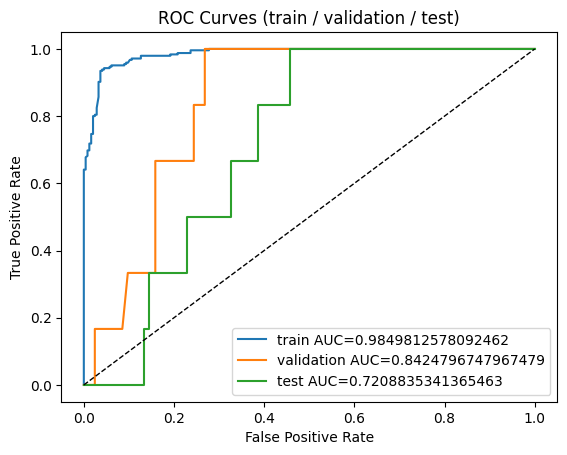

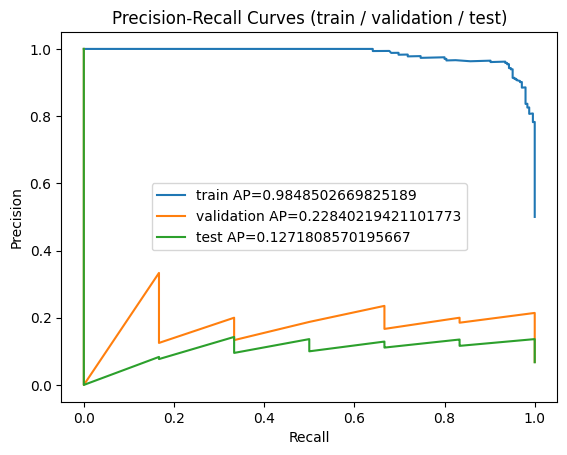

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.datasets import load_svmlight_file
import glob

# Plot ROC curves for all splits
plt.figure()
for file, uri in split_uris.items():
    y = load_svmlight_file(uri.replace("file://", ""))[1]
    outs = sorted(glob.glob(f"./batch-preds/{file}/*.out"))
    preds = np.concatenate([np.loadtxt(p, delimiter=",") for p in outs])
    fpr, tpr, _ = roc_curve(y, preds)
    auc = roc_auc_score(y, preds)
    plt.plot(fpr, tpr, label=f"{file} AUC={auc}")

plt.plot([0,1], [0,1], "k--", linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (train / validation / test)")
plt.legend()
plt.show()

# Plot PR curves for all splits
plt.figure()
for file, uri in split_uris.items():
    y = load_svmlight_file(uri.replace("file://", ""))[1]
    outs = sorted(glob.glob(f"./batch-preds/{file}/*.out"))
    preds = np.concatenate([np.loadtxt(p, delimiter=",") for p in outs])
    precision, recall, _ = precision_recall_curve(y, preds)
    ap = average_precision_score(y, preds)
    plt.plot(recall, precision, label=f"{file} AP={ap}")

plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curves (train / validation / test)")
plt.legend()
plt.show()

The ROC curve usually looks very good on an imbalanced dataset, because most true negatives are easy to predict and make up the majority of the dataset. However, the PR curve is a better indicator of the actual performance of a detection algorithm.

In this case, the model appears to be overfitting, it performs very well on the training set but significantly worse on the validation (and test) sets. To improve an overfitting model, we should aim for a simpler and more generalized model. For example, reducing the tree depth or applying regularization techniques (such as L1 or L2) may help. However, when there is not enough training data, the model becomes more prone to overfitting, as it tends to memorize the training set rather than learn generalized patterns.

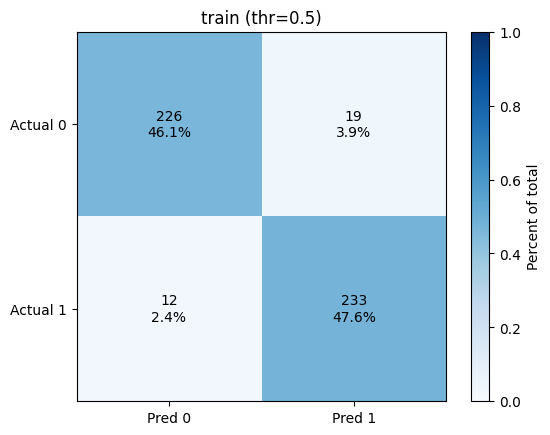

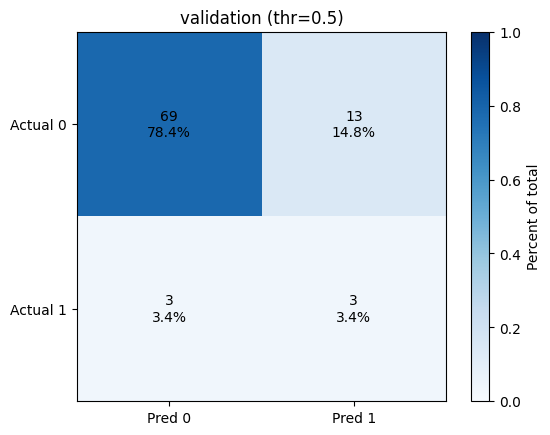

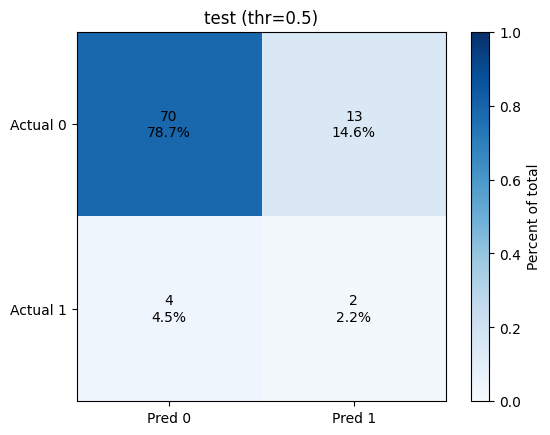

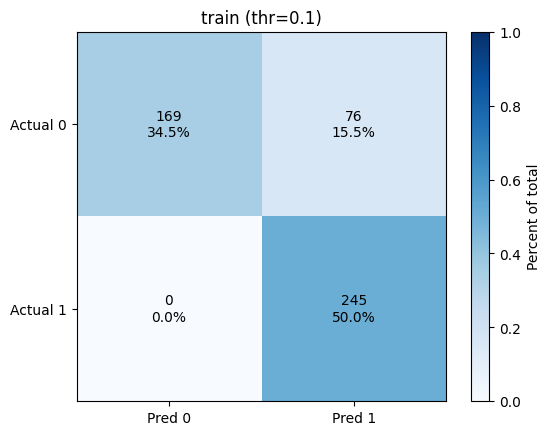

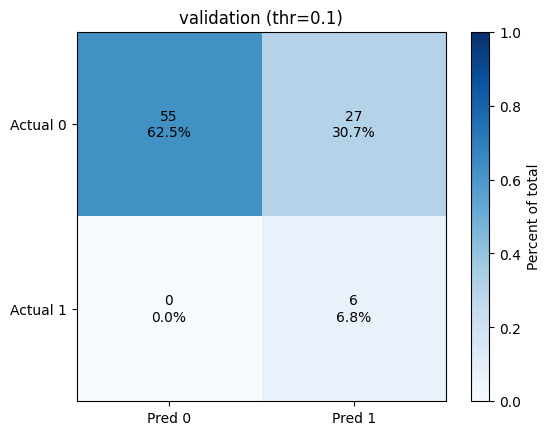

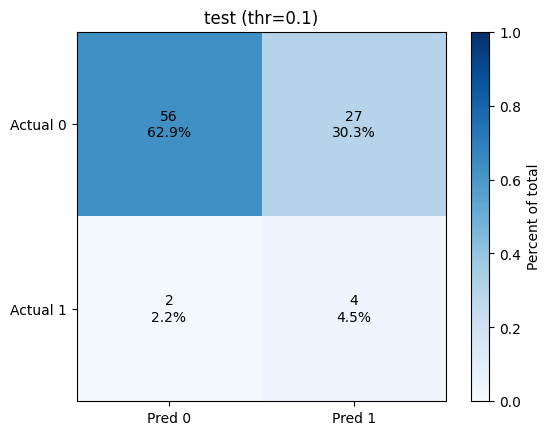

In [7]:
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import confusion_matrix
import numpy as np, glob, matplotlib.pyplot as plt

for thr in [0.5, 0.1]:
    for file, uri in split_uris.items():
        y = load_svmlight_file(uri.replace("file://",""))[1]
        p = sorted(glob.glob(f"./batch-preds/{file}/*.out"))[0]
        preds = np.loadtxt(p, delimiter=",")
        yhat = (preds >= thr).astype(int)
        cm = confusion_matrix(y, yhat, labels=[0,1])
        pct = cm / cm.sum()

        plt.figure()
        plt.imshow(pct, cmap="Blues", vmin=0, vmax=1)
        for i in range(2):
            for j in range(2):
                plt.text(j, i, f"{cm[i,j]}\n{pct[i,j]:.1%}", ha="center", va="center")
        plt.xticks([0,1], ["Pred 0","Pred 1"])
        plt.yticks([0,1], ["Actual 0","Actual 1"])
        plt.title(f"{file} (thr={thr})")
        plt.colorbar(label="Percent of total")
        plt.show()

Notice that we used different thresholds and achieved very different results on the same model. At a threshold of 0.5, the model was able to catch 2 out of 6 actual positives, while at a threshold of 0.1, it caught 4 out of 6 positives. However, this improvement in recall came at the expense of more false positives, which lowered precision. This illustrates the trade-off between precision and recall.

The real question is, "How expensive is it to miss an actual positive case, versus how expensive is it to overreact with a false positive?" If we can quantify these costs, then we can select the decision threshold more wisely.

## Threshold Optimzation

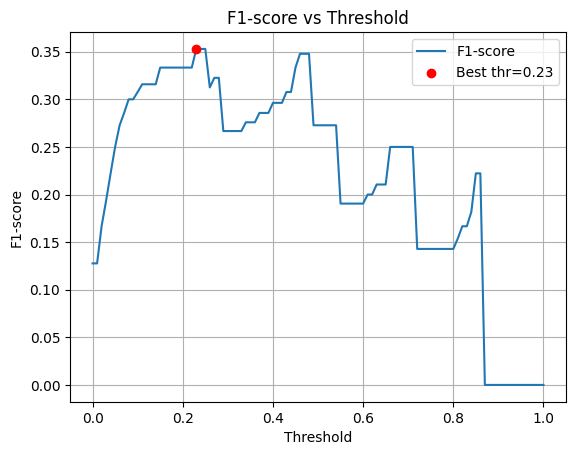

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Load validation labels
_, y_val = load_svmlight_file("ml-local/validation.libsvm")
preds = np.loadtxt("./batch-preds/validation/validation.libsvm.out", delimiter=",")

# Sweep thresholds
thresholds = np.linspace(0, 1, 101)
f1s = [f1_score(y_val, (preds > thr).astype(int)) for thr in thresholds]

# Find best
best_idx = int(np.argmax(f1s))
best_thr, best_f1 = thresholds[best_idx], f1s[best_idx]

# Plot
plt.plot(thresholds, f1s, label="F1-score")
plt.scatter([best_thr], [best_f1], color="red", zorder=5, label=f"Best thr={best_thr:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("F1-score vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

Here is a demonstration of systematically optimizing the decision threshold for the F1-score (the harmonic mean between precision and recall). The results show that a threshold of 0.23 gives us the best value, maximizing the F1-score on the validation set.

# Model Interpretation

,feature,mean_abs_shap
0,f0,2.340631
1,f7,0.969145
2,f2,0.528000
3,f6,0.396079
4,f1,0.374359
5,f4,0.361335
6,f3,0.035294
7,f5,0.016432


Metadata: {'job_dir': 'model/stroke-xgb-t2-ml.m5.large-2025-09-26-17-24-20-e07e1d/output', 'explain_dir': 'model/stroke-xgb-t2-ml.m5.large-2025-09-26-17-24-20-e07e1d/explain', 'data_path': 'ml-local/test.libsvm?format=libsvm', 'n_rows': 89, 'n_features': 8, 'top_features': [{'feature': 'f0', 'mean_abs_shap': 2.3406310081481934}, {'feature': 'f7', 'mean_abs_shap': 0.9691453576087952}, {'feature': 'f2', 'mean_abs_shap': 0.5279996991157532}, {'feature': 'f6', 'mean_abs_shap': 0.3960791528224945}, {'feature': 'f1', 'mean_abs_shap': 0.3743588328361511}, {'feature': 'f4', 'mean_abs_shap': 0.3613351583480835}, {'feature': 'f3', 'mean_abs_shap': 0.03529366850852966}, {'feature': 'f5', 'mean_abs_shap': 0.016432320699095726}], 'created_at': '2025-09-26T17:24:33', 'model_artifact': 'model/stroke-xgb-t2-ml.m5.large-2025-09-26-17-24-20-e07e1d/output/model.tar.gz', 'params': {'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'num_round': 200, 'eta': 0.03731143088741836, 'max_depth': 7, 'min_ch

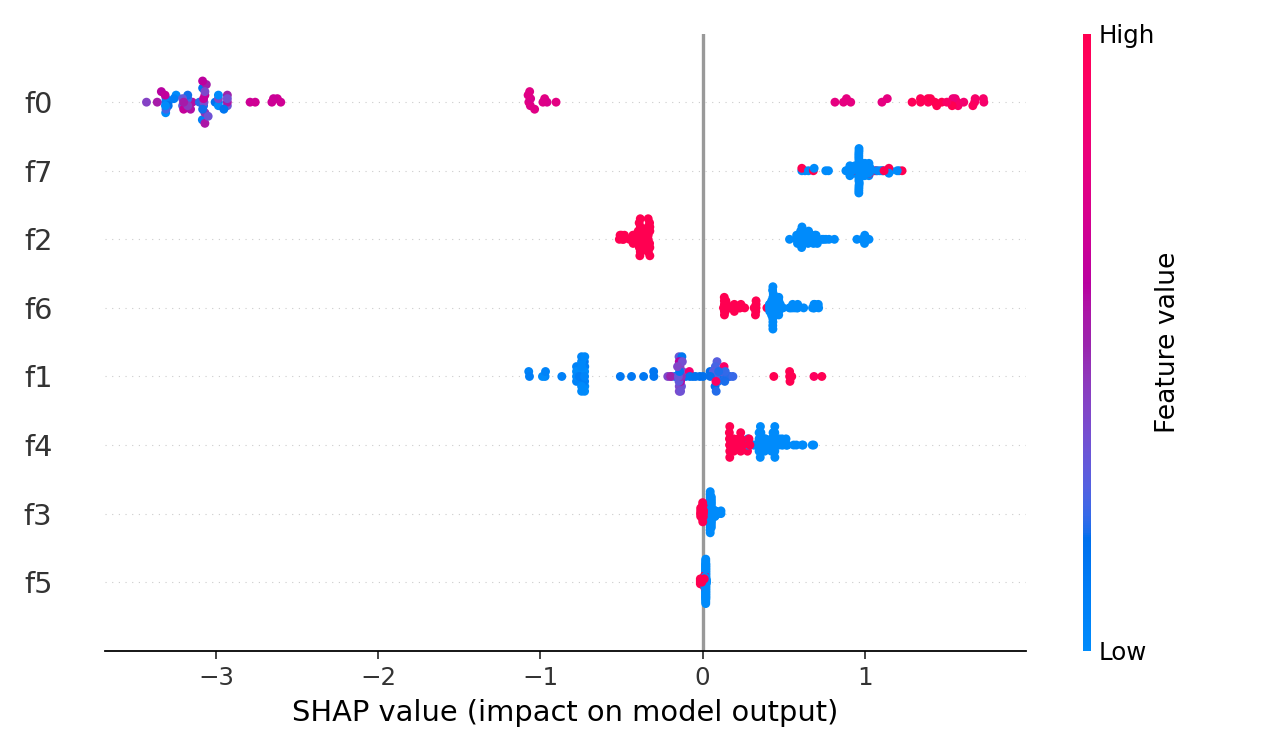

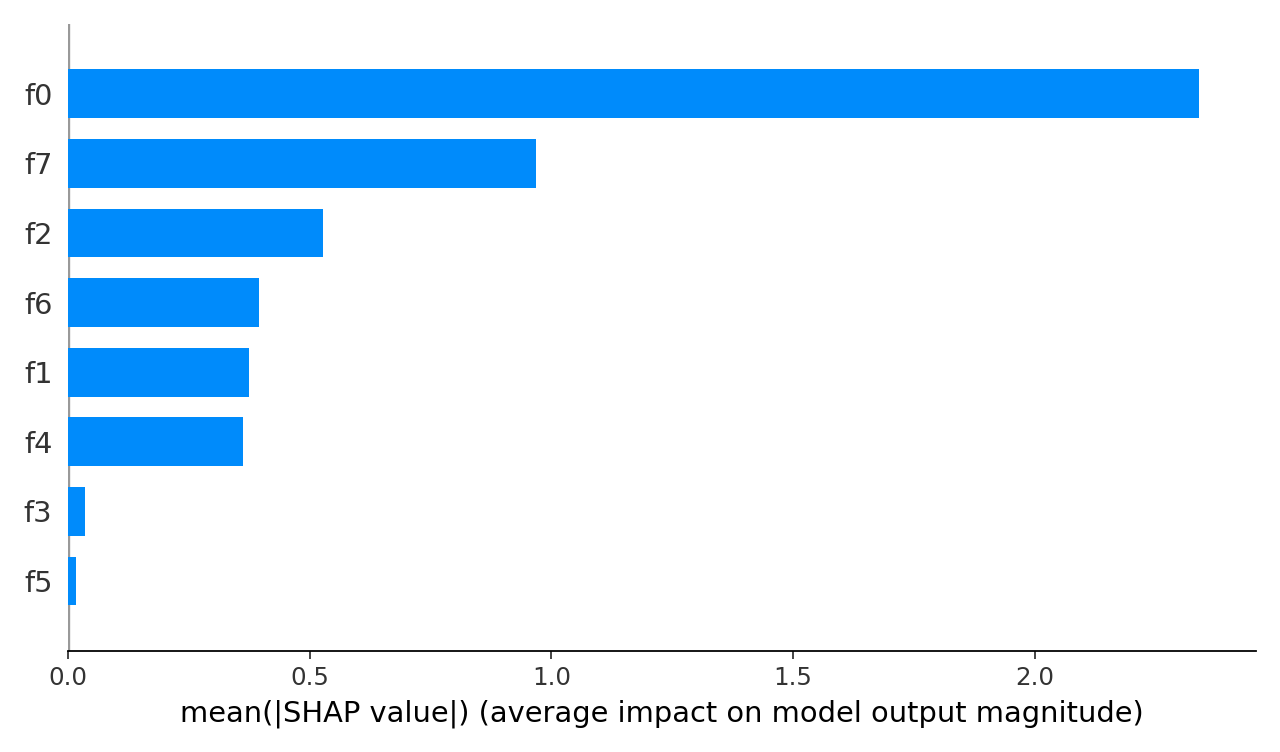

In [9]:
import pandas as pd, json, glob
from IPython.display import Image, display

out_dir = best_est.explain(
    data_path="file://ml-local/test.libsvm",
    top_k=20,
    out_subdir="explain"
)

# Load SHAP summaries
shap_summary = pd.read_csv(f"{out_dir}/shap_summary.csv")
display(shap_summary.head(10))  # top features

# Load JSON report
with open(f"{out_dir}/explain_report.json") as f:
    report = json.load(f)
print("Metadata:", report)

# Show images (any PNG in the folder)
for img in glob.glob(f"{out_dir}/*.png"):
    display(Image(filename=img))

In [10]:
# Suppose your original dataframe has these columns
real_cols = df.columns.tolist()

# Create a mapping from f0...fN to real feature names
fmap = {f"f{i}": col for i, col in enumerate(real_cols)}

# Example usage: rename in a SHAP summary DataFrame
shap_summary["feature_name"] = shap_summary["feature"].map(fmap)

shap_summary

,feature,mean_abs_shap,feature_name
0,f0,2.340631,gender
1,f7,0.969145,avg_glucose_level
2,f2,0.528000,hypertension
3,f6,0.396079,residence_type
4,f1,0.374359,age
5,f4,0.361335,ever_married
6,f3,0.035294,heart_disease
7,f5,0.016432,work_type


We can analyze the model by creating an explanation job, which calculates the SHAP values for each feature in the dataset. Each feature is denoted as f0, f1, ... fn, referencing back to the original dataset, so that we can bring all information together.

In this case, the feature with the greatest impact is gender, followed by average glucose level and hypertension, based on the mean absolute SHAP value. These features are the primary predictors that determine stroke risk in this dataset.

## Summary

We have walked through how to ingest a large dataset into S3, using PySpark and distributed computing to transform and clean the raw data. After that, we explored the dataset with visualization, applied additional transformations, and then prepared the data for modeling. Finally, we preprocessed the features, trained the model, and performed hyperparameter tuning with SageMaker.

To improve the model, we can apply additional regularization techniques or increase the size of the training dataset. When more data is not available, the model can still be launched in production with a setup for continuous learning. This way, new data can be incorporated through periodic retraining. It is also important to enable monitoring to track model performance and set alerts for data drift.

For further experiments, we can use SageMaker Experiments to test combinations of hyperparameters and engineered features to see which yield performance gains. Once we identify a promising candidate, we can deploy it as a production variant to test with limited traffic before routing all requests to the new model.


**Thanks you,**

**Louis Wong**

## Contact

If you would like to learn more about my work or reach out to me personally, please send your inquiry to:  

**Email:** imlouiswong@gmail.com